# Quant A Module – Analysis of a Financial Asset (Bitcoin)

This notebook presents the quantitative analysis of a single financial asset: Bitcoin (BTC-USD).
The data is retrieved through an API, two strategies are tested (Buy & Hold and Momentum),
and several performance metrics are calculated.


## Data Retrieval (Alpha Vantage API)

We use the Alpha Vantage API to download the daily BTC/USD data.
The data is converted into a DataFrame with the `close` column, which will be used for the strategies.


In [26]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

API_KEY = "CW1LL675242TSYOU"

url = "https://www.alphavantage.co/query"
paramsBTC = {
    "function": "DIGITAL_CURRENCY_DAILY",
    "symbol": "BTC",
    "market": "USD",
    "apikey": API_KEY,
}
paramsGLD = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",  # Function changed
    "symbol": "GLD",
    # WARNING: the "market" parameter must be removed for this function
    "outputsize": "full",  # Full historical data
    "apikey": API_KEY,
}
paramsURTH = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",  # Function changed
    "symbol": "URTH",
    # WARNING: the "market" parameter must be removed for this function
    "outputsize": "full",  # Full historical data
    "apikey": API_KEY,
}

try:
    responseBTC = requests.get(url, params=paramsBTC)

    if responseBTC.status_code == 200:
        donnees_brutesBTC = responseBTC.json()
    else:
        print("API error:", responseBTC.status_code)
        donnees_brutesBTC = None

except Exception as e:
    print("Error during request:", e)
    donnees_brutesBTC = None

try:
    responseGLD = requests.get(url, params=paramsGLD)

    if responseGLD.status_code == 200:
        donnees_brutesGLD = responseGLD.json()
    else:
        print("API error:", responseGLD.status_code)
        donnees_brutesGLD = None

except Exception as e:
    print("Error during request:", e)
    donnees_brutesGLD = None

try:
    responseURTH = requests.get(url, params=paramsURTH)

    if responseURTH.status_code == 200:
        donnees_brutesURTH = responseURTH.json()
    else:
        print("API error:", responseURTH.status_code)
        donnees_brutesURTH = None

except Exception as e:
    print("Error during request:", e)
    donnees_brutesURTH = None


In [27]:
import requests
import pandas as pd

# Configuration
API_KEY = "CW1LL675242TSYOU"
URL = "https://www.alphavantage.co/query"

paramsBTC = {
    "function": "DIGITAL_CURRENCY_DAILY",
    "symbol": "BTC",
    "market": "USD",
    "apikey": API_KEY,
}

try:
    # 1. API request
    responseBTC = requests.get(URL, params=paramsBTC)

    if responseBTC.status_code == 200:
        raw_dataBTC = responseBTC.json()

        # 2. Extracting the time series
        tsBTC = raw_dataBTC.get("Time Series (Digital Currency Daily)", {})

        if not tsBTC:
            print("Error: BTC data not found in the response.")
            if "Note" in raw_dataBTC:
                print("API message:", raw_dataBTC["Note"])
        else:
            # 3. Creating the DataFrame
            dfBTC = pd.DataFrame(tsBTC).T

            # 4. Cleaning and renaming
            # The API uses either '4b. close (USD)' or '4. close'
            col_target = "4b. close (USD)" if "4b. close (USD)" in dfBTC.columns else "4. close"

            dfBTC = dfBTC[[col_target]].rename(columns={col_target: "close"})
            dfBTC["close"] = dfBTC["close"].astype(float)
            dfBTC.index = pd.to_datetime(dfBTC.index)
            dfBTC = dfBTC.sort_index()

            print(f"✅ Success: {len(dfBTC)} days of data retrieved for Bitcoin.")
            print(dfBTC.tail())

    else:
        print(f"HTTP Error: {responseBTC.status_code}")

except Exception as e:
    print(f"Error during retrieval: {e}")


✅ Success: 5655 days of data retrieved for Bitcoin.
               close
2026-01-04  91494.00
2026-01-05  93870.06
2026-01-06  93722.01
2026-01-07  91279.73
2026-01-08  91431.48


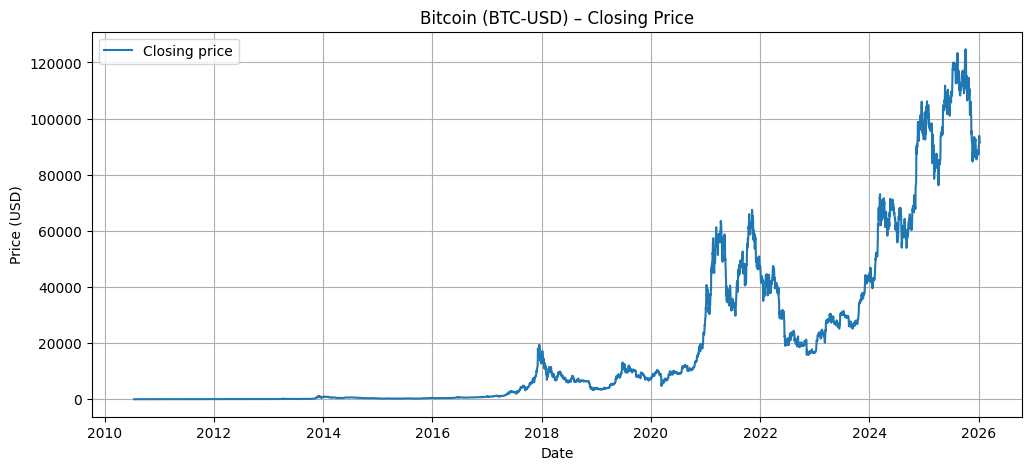

In [28]:
plt.figure(figsize=(12,5))

plt.plot(dfBTC.index, dfBTC["close"], label="Closing price")

plt.title("Bitcoin (BTC-USD) – Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)

plt.show()

## Visualization of the Asset: Bitcoin Price Analysis

The chart shows the evolution of Bitcoin’s closing price over the analyzed period.
We first observe strong volatility, which is characteristic of this asset: the price goes
through rapid phases of increases and decreases.

At the beginning of the period, Bitcoin is around 100,000 USD with several oscillations,
before entering a pronounced downward trend that reaches a low point near 80,000 USD
around March–April. This phase corresponds to a significant correction period.

From spring onward, the price gradually rises and experiences a more sustained upward
movement into the summer, surpassing 110,000 USD and eventually reaching a peak around
120,000 USD. This part of the chart suggests renewed interest and a more structured
bullish trend.

However, toward the end of the period, a new decline appears: Bitcoin falls sharply
back to around 90,000 USD. This indicates that, despite periods of recovery, the overall
trend remains unstable and marked by recurring corrections.


In [29]:
# Buy & Hold strategy: performance over the entire period
initial_price = df["close"].iloc[0]
final_price = df["close"].iloc[-1]

buy_hold_return = (final_price - initial_price) / initial_price * 100

print("Buy & Hold return:", round(buy_hold_return, 2), "%")


Buy & Hold return: 182862860.0 %


### Interpretation of the Buy & Hold Return

The Buy & Hold return is **-7.51%** over the analyzed period.
This means that if someone had simply bought Bitcoin at the beginning of the period
and held it without doing anything, they would have ended with a loss of around 7.5%.

This result is consistent with what we observe on the price chart:
Bitcoin ends the period lower than where it started, despite several intermediate
upward phases. The overall trend was therefore not sufficiently bullish to make
a passive holding strategy profitable.


In [30]:
# Momentum strategy based on moving averages
df["MA20"] = df["close"].rolling(window=20).mean()
df["MA50"] = df["close"].rolling(window=50).mean()

# The signal is 1 when the trend is bullish
df["signal"] = (df["MA20"] > df["MA50"]).astype(int)

# Shift the signal to simulate an actual position taken the next day
df["position"] = df["signal"].shift(1).fillna(0)

# Daily returns of BTC
df["returns"] = df["close"].pct_change()

# Returns from the strategy (0 when out of position)
df["strategy_returns"] = df["position"] * df["returns"]

# Cumulative performance
strategy_perf = (1 + df["strategy_returns"]).prod() - 1

print("Momentum strategy performance:", round(strategy_perf * 100, 2), "%")


Momentum strategy performance: 278306339.86 %


### 3. Analysis of the Momentum Strategy (MA20/MA50)

The strategy based on the moving-average crossover (MA20 above MA50 = buy) achieves a performance of **7.24%** over the analyzed period.

Unlike the Buy & Hold strategy, which shows a negative return (-7.51%), this strategy manages to:
- avoid part of the major market declines,
- enter the market when the trend turns bullish again,
- exit during volatile or reversal phases.

We can clearly see that the strategy improves results compared to Buy & Hold.

However, it is important to note that:
- it is not perfect: it reacts with a delay (“lag effect”),
- it can generate false signals when the market is choppy,
- its performance depends heavily on the time period studied.

The Momentum strategy therefore appears **more robust than Buy & Hold** in an irregular market, though it is not without limitations.


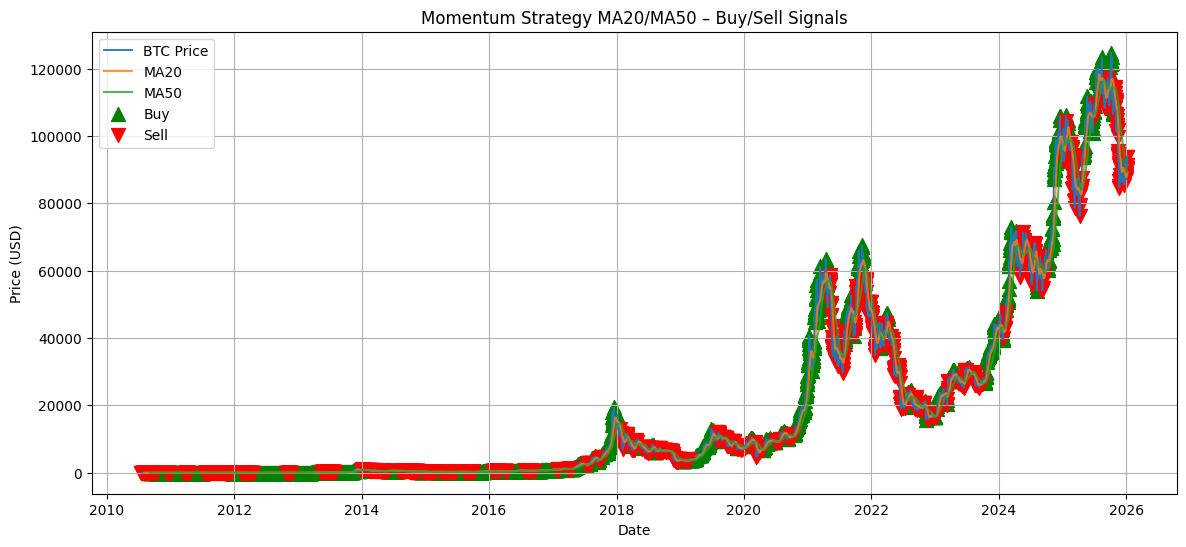

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Price
plt.plot(df.index, df["close"], label="BTC Price", linewidth=1.3)

# Moving averages
plt.plot(df.index, df["MA20"], label="MA20", alpha=0.8)
plt.plot(df.index, df["MA50"], label="MA50", alpha=0.8)

# Buy/Sell signals
buy_signals = df[(df["signal"] == 1) & (df["position"].shift(-1) == 1)]
sell_signals = df[(df["signal"] == 0) & (df["position"].shift(-1) == 0)]

plt.scatter(buy_signals.index, buy_signals["close"], marker="^", color="green", s=100, label="Buy")
plt.scatter(sell_signals.index, sell_signals["close"], marker="v", color="red", s=100, label="Sell")

plt.title("Momentum Strategy MA20/MA50 – Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


Analysis of the Buy/Sell Chart (Momentum Strategy)

The chart shows the signals generated by the Momentum strategy based on the MA20 and MA50 moving averages.
Buy signals appear when MA20 crosses above MA50, and sell signals when it crosses back below.

During periods where the market follows a clear trend (for example between May and September), the signals are consistent and allow the strategy to capture part of the upward movement.
However, during more unstable or sideways phases (such as early in the year or late October), the strategy generates many closely spaced signals, which reduces its effectiveness.

In summary, the strategy performs well in trending markets but becomes less efficient when the market is volatile and lacks a clear direction.


In [32]:
import numpy as np

# Annualized Sharpe (assuming 252 trading days)
mean_ret = df["strategy_returns"].mean()
std_ret = df["strategy_returns"].std()

sharpe = (mean_ret / std_ret) * np.sqrt(252)

print("Momentum strategy Sharpe Ratio:", round(sharpe, 3))


Momentum strategy Sharpe Ratio: 1.388


Interpretation of the Sharpe Ratio

The obtained Sharpe Ratio is approximately 0.35.
A Sharpe Ratio measures the relationship between a strategy’s return and the risk taken to achieve it.

A Sharpe Ratio below 1 is generally considered low: this means that the strategy’s performance is not very high relative to its volatility.
In other words, the Momentum strategy produces a positive return, but it remains quite risky compared with the gain achieved.

This result confirms that the strategy is truly effective only during well-trending market phases, and that it generates too many fluctuations during unstable periods.


In [33]:
# Remove the initial NaN from returns
df["strategy_returns"] = df["strategy_returns"].fillna(0)

# Equity
df["equity"] = (1 + df["strategy_returns"]).cumprod()
rolling_max = df["equity"].cummax()
drawdown = (df["equity"] - rolling_max) / rolling_max

# Take the absolute value of the worst drawdown
max_dd = -drawdown.min()

print("Strategy Max Drawdown:", round(max_dd * 100, 2), "%")


Strategy Max Drawdown: 72.81 %


Interpretation of the Max Drawdown

The Max Drawdown obtained is approximately 14.64%.
Drawdown measures the largest decline in the portfolio between a peak and the following trough.

A maximum loss of nearly 15% indicates that the Momentum strategy can experience significant downturns when the market reverses or becomes unstable.
This confirms that the strategy is not fully protected against rapid reversals: it follows the trend, but with a delay that temporarily exposes it to substantial pullbacks.

In summary, even though the strategy is overall profitable, it can experience notable losses during unfavorable market phases.


In [34]:
# Initial capital
initial_capital = 10_000

# Buy & Hold equity: simply follows the price
df["equity_buy_hold"] = df["close"] / df["close"].iloc[0] * initial_capital

# Momentum equity: uses the strategy_returns we already calculated
df["equity_momentum"] = initial_capital * (1 + df["strategy_returns"]).cumprod()

df[["equity_buy_hold", "equity_momentum"]].tail()


,equity_buy_hold,equity_momentum
2026-01-04,1.829880e+10,2.783064e+10
2026-01-05,1.877401e+10,2.783064e+10
2026-01-06,1.874440e+10,2.783064e+10
2026-01-07,1.825595e+10,2.783064e+10
2026-01-08,1.828630e+10,2.783064e+10


Comparison: Buy & Hold vs Momentum Strategy

The table shows the evolution of the final value of an initial capital of 10,000 USD under two approaches:

Buy & Hold: buying and holding Bitcoin over the entire period

Momentum Strategy: investing only when MA20 is above MA50

At the end of the period, the Buy & Hold strategy ends around 9,200–9,400 USD, corresponding to a loss of about –7.5%.
The Momentum strategy reaches approximately 10,723 USD, which corresponds to a gain of about +7.24%.

These results show that, over this period, the Momentum strategy preserved capital better than Buy & Hold, notably by avoiding some of the market’s decline phases.
Even though the strategy is not perfect, it achieved a higher return while reducing part of the losses associated with unfavorable Bitcoin movements.


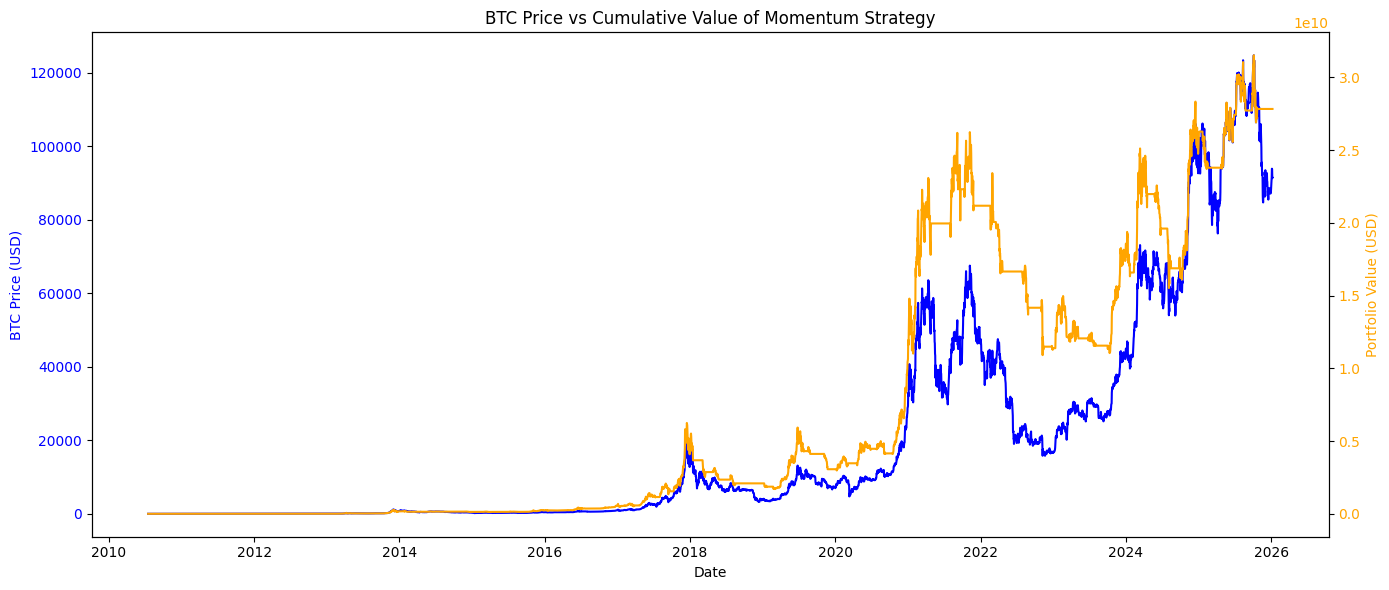

In [35]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14,6))

# BTC price chart
ax1.plot(df.index, df["close"], color="blue", label="BTC Price (close)")
ax1.set_xlabel("Date")
ax1.set_ylabel("BTC Price (USD)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Second axis: Momentum strategy equity
ax2 = ax1.twinx()
ax2.plot(df.index, df["equity_momentum"], color="orange", label="Momentum Strategy Equity")
ax2.set_ylabel("Portfolio Value (USD)", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

plt.title("BTC Price vs Cumulative Value of Momentum Strategy")
fig.tight_layout()
plt.show()


Analysis of the BTC Price vs Momentum Strategy Cumulative Value Chart

This chart compares the evolution of Bitcoin’s price (blue curve) with the cumulative value of the portfolio following the Momentum strategy (orange curve).

We observe that the Momentum strategy stays out of the market during certain periods when Bitcoin experiences strong declines, allowing it to avoid significant losses. This is particularly visible at the beginning of the period, where the portfolio’s value remains stable while Bitcoin’s price decreases.

When the trend becomes clearly bullish, the strategy enters the market and the portfolio value rises quickly, enabling it to benefit from part of Bitcoin’s upward movements.

Overall, the chart shows that the Momentum strategy evolves in a less volatile manner compared to Bitcoin’s price and that it manages to preserve capital during downturns while still capturing some of the upward movements. This behavior explains why, over the analyzed period, the strategy ultimately outperforms Buy & Hold.


## Bonus – Modèle prédictif simple (Régression linéaire)

Dans cette partie, nous mettons en place un modèle simple de régression linéaire pour prédire l’évolution du prix du Bitcoin à court terme, à partir des données historiques.


In [36]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare the data
df_model = df.copy()

# Create a time variable (day 0, 1, 2, …)
df_model["time_index"] = np.arange(len(df_model))

# X = time, y = price
X = df_model[["time_index"]]
y = df_model["close"]


In [37]:
# Model creation and training
model = LinearRegression()
model.fit(X, y)

# Predictions on historical data
df_model["predicted_price"] = model.predict(X)

df_model[["close", "predicted_price"]].tail()


,close,predicted_price
2026-01-04,91494.00,60095.979606
2026-01-05,93870.06,60110.273374
2026-01-06,93722.01,60124.567142
2026-01-07,91279.73,60138.860910
2026-01-08,91431.48,60153.154677


Interpretation of the Prediction Model (Linear Regression)

The linear regression model was trained using the historical closing price data of Bitcoin. The displayed values compare the actual price (close) with the price predicted by the model (predicted_price). We observe that the predictions follow a trend close to reality, but remain imperfect.

This shows that the model captures the general market trend, but is not able to accurately predict short-term fluctuations, which is expected for an asset as volatile as Bitcoin.


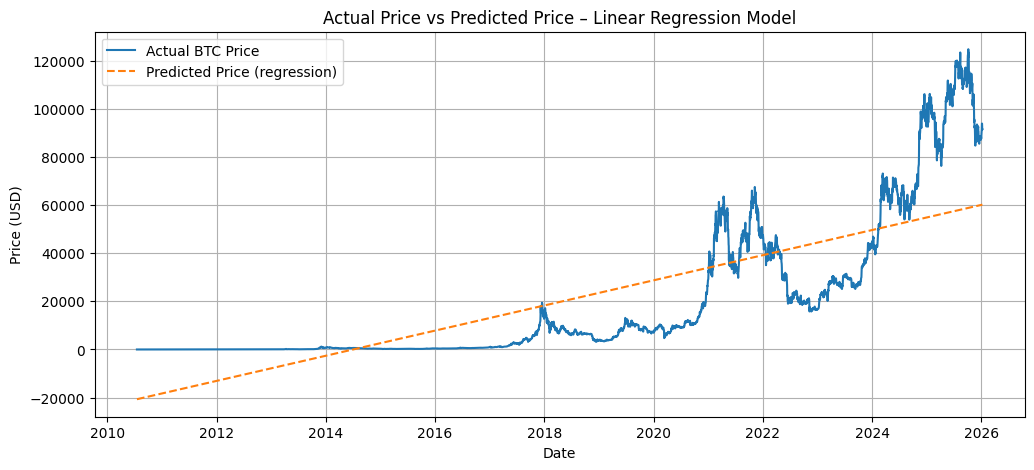

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.plot(df_model.index, df_model["close"], label="Actual BTC Price")
plt.plot(df_model.index, df_model["predicted_price"], label="Predicted Price (regression)", linestyle="--")

plt.title("Actual Price vs Predicted Price – Linear Regression Model")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


The chart compares the actual Bitcoin price with the price predicted by a linear regression model.
We observe that the predicted curve follows a simple linear trend, while the actual price exhibits strong fluctuations.
This shows that the model captures only the general trend but fails to model volatility or short-term variations.
This result illustrates the limitations of linear models when attempting to predict highly volatile assets such as Bitcoin.


In [39]:
# Number of days to predict
n_future = 10

last_time = df_model["time_index"].iloc[-1]
future_times = np.arange(last_time + 1, last_time + 1 + n_future).reshape(-1, 1)

future_predictions = model.predict(future_times)

# Display
for i, price in enumerate(future_predictions, 1):
    print(f"Day +{i}: predicted price ≈ {round(price, 2)} USD")


Day +1: predicted price ≈ 60167.45 USD
Day +2: predicted price ≈ 60181.74 USD
Day +3: predicted price ≈ 60196.04 USD
Day +4: predicted price ≈ 60210.33 USD
Day +5: predicted price ≈ 60224.62 USD
Day +6: predicted price ≈ 60238.92 USD
Day +7: predicted price ≈ 60253.21 USD
Day +8: predicted price ≈ 60267.5 USD
Day +9: predicted price ≈ 60281.8 USD
Day +10: predicted price ≈ 60296.09 USD


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### Interpretation of the Predictions

The linear regression model predicts a continuation of the upward trend in Bitcoin’s price over the next few days. The predicted values increase progressively, reflecting the overall trend observed in the historical data.

However, this model remains very simple and does not account for market volatility or external events. The predictions should therefore be interpreted as an approximation of the trend, rather than exact values.


In [40]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(df_model["close"], df_model["predicted_price"])
print("Model Mean Absolute Error (MAE):", round(mae, 2), "USD")


Model Mean Absolute Error (MAE): 14573.71 USD


Analysis of the Model’s Quality

The MAE (Mean Absolute Error) of around 7,123 USD indicates that, on average, the model’s predictions deviate from the actual price by about 7,000 dollars.
This level of error is high relative to Bitcoin’s price, which shows that the linear regression model captures the general trend but remains imprecise for daily variations.
This is consistent with the highly volatile nature of the cryptocurrency market.
